In [69]:
import os
from time import time

from matplotlib import pyplot as plt
import numpy as np
from spectral.io import envi

import isofit
from isofit.utils.apply_oe import apply_oe 
from isofit.core.common import envi_header
from isofit import ray

BANDS = [43, 20, 12]

In [70]:
# Useful functions and constants
def normalize_im(data, vmin=0, vmax=15):
    norm_data = (data - vmin) / (vmax - vmin)

    return norm_data

# <center>Simultaneous Retrievals of Surface Reflectance, Glint, and Atmospheric State with Isofit and ApplyOE</center>

This is an end-to-end walkthrough to generate estimates of the surface reflectance, atmospheric state and water surface glint. The procedure presented leverages the ability of Isofit to apply different surface models to different groupings of pixels (multisurface mode). In this example, the instrument and radiative transfer portions of the forward model will remain constant across the entire image, but the _surface_ portion of the forward model will differ between water and land pixels. To accomodate this unique procedure, ApplyOE has to be configured in a specific manner with the correct input data. 

The outline for this tutorial is as follows:
1. Introducing the data cube
2. Generating and saving a simple water mask
3. Setting up the ApplyOE inputs
4. Executing ApplyOE
5. Examining the outputs

## 1. Introducing the data cube

We start with a 500x500 pixel data cube (emit20240822T090158) from the EMIT mission. The data was recorded on August 22nd, 2024 and is located off of the coast of Greece, centered approximately at Latitude: 37.457N, Longitude: 23.460W.

Download tutorial data from PLACEHOLDER: https://avng.jpl.nasa.gov/pub/PBrodrick/isofit/tutorials/subset_data.zip. 

In [71]:
# Load the data
root = os.path.abspath(os.getcwd())
rdn_path = os.path.join(root, 'emit20240822T090158_rdn')
rdn = envi.open(envi_header(rdn_path))
rdn_im = rdn.load()
wl = np.array([float(i) for i in rdn.metadata['wavelength']])

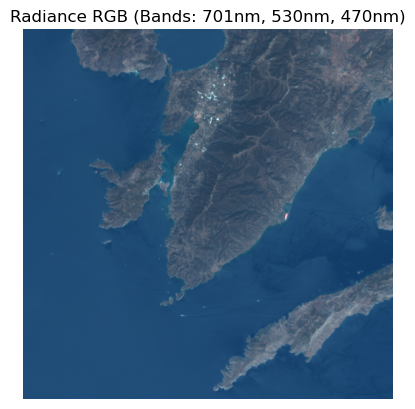

In [72]:
plt.imshow(normalize_im(rdn_im[..., BANDS]))
plt.axis('off')
plt.title('Radiance RGB (Bands: 701nm, 530nm, 470nm)') 
plt.show()

## 2. Generating and saving a simple water mask

Running Isofit in "Multisurface mode" requres an additional input, __an integer mask__, which maps groupings of pixels within the image to forward model configurations to use when inverting those groups. The advantage of using an integer mask is that it is flexible; one could represent pixel groupings of n-number of pixel groupings and construct a variety of different forward model configurations. The disadvantage of using an external integer mask is that the file has to be structured in a particular manner to run successfully.

Here, I will 1) walk through a _very_ simple classification of the example image and then 2) show you how to construct the classification file correctly.


### 2.1 Water classification

There are a hundred methods to classify water from spectra. The goal here is not to provide the _best_ method to do so, but rather to present one extremely simple method to do so. 

We present a classification scheme based on the assumption that the curvature of radiance spectra at long wavelengths (> 1500 nm) will be significantly smaller for water pixels than the curvature in the equivalent spectral region for land pixels. 

The method:
1. Normalizes the spectra between 0 -> 1
2. Calculates the 95th percentile curvature of the radiance spectra for each pixel between 1500nm - 1800 nm
3. Uses a manually tuned threshold (1.8e-5) to separate water pixels (k <= thresh) from land pixels (k > thresh)

The manually tuned threshold value will likely vary from scene-to-scene and the one used here does not necessarily represent the most accurate value across scenes.

In [73]:
# Water Masking functions
def normalize_spec(spec):
    return (spec - spec.min()) / (spec.max() - spec.min())


def get_curvature(spec, wl, window=[1500, 1800]):
    x = wl[(wl > window[0]) & (wl < window[1])]
    y = spec[(wl > window[0]) & (wl < window[1])]

    z = np.polyfit(x, y, 2)

    dy1 = (2 * z[0] * x) + z[1]
    dy2 = z[0] * 2
    k = np.percentile(np.abs(dy2) / ((1 + (dy1**2))**(3/2)), 95)

    return k

In [74]:
# Classify image - This will take ~15s
thresh = 1.8e-5
cim = np.zeros((rdn_im.shape[0], rdn_im.shape[1]))
kim = np.zeros((rdn_im.shape[0], rdn_im.shape[1]))
for r in range(rdn_im.shape[0]):
    for c in range(rdn_im.shape[1]):
        spec = np.squeeze(rdn_im[r, c, :])
        k = get_curvature(spec, wl)

        kim[r, c] = k

        if k > thresh:
            cim[r, c] = 1

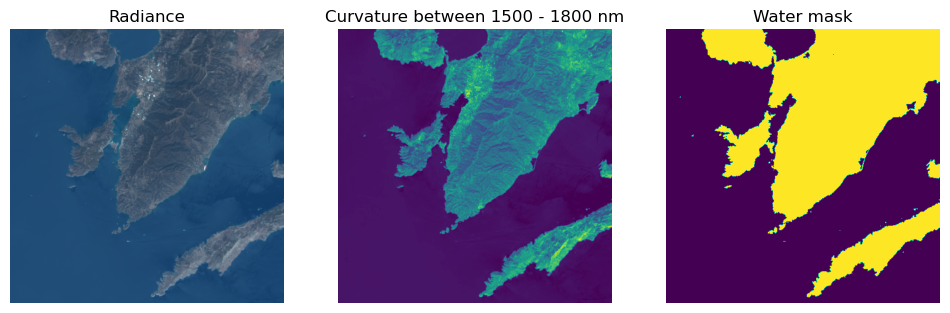

In [75]:
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12,5))
axs[0].set_title('Radiance')
axs[0].imshow(normalize_im(rdn_im[..., BANDS]))

axs[1].set_title('Curvature between 1500 - 1800 nm')
axs[1].imshow(kim)

axs[2].set_title('Water mask')
axs[2].imshow(cim)

axs[0].axis('off')
axs[1].axis('off')
axs[2].axis('off')
plt.show()

### 2.2 Saving the classification image

The water classification generated above has to be saved to a path because the inputs to the ApplyOE program are file paths. We will be saving the surface classfication image as a binary ENVI file (it's the only file type ApplyOE currently supports). We will also leverage the header (.hdr) file accompanying the binary file to carry the information of how the ApplyOE program should interpret and ultimately use the classification file.

ENVI headers are sturctured as key-value pairs. To be succesfully ingested into ApplyOE, the classification image needs a specific header key which contains the pixel classification names for each integer value present in the image. Consider the header file key-values:
```python
header = {
    'lines': class_im.shape[0],
    'samples': class_im.shape[1],
    'bands': 1,
    'header offset': '0',
    'file type': 'ENVI Standard',
    'data type': '4',
    'interleave': 'bil',
    'byte order': '0',
    'band names': ['Classification'],
    'mapping': ['water', 'land']
}
```

This is a one band image (name: Classification) with the line and sample numbers equal to the row-col dimensions. The critical entry to notice is the key "__mapping__". The associated value is a list of the surface classes (water and land). The order of the surface class list is important, and corresponds to the integer value in the classification image. I'll use python list indexing here... For example, 'water' is the 0th entry in the list, and corresponds to pixels within the image with values of 0. Alternatively, 'land' is the 1st entry in the list, and corresponds to pixels within the image with values of 1.

We've built some flexibility into the key and value naming convention. 

ApplyOE will recognize the following key names:
```python
[
    "mapping",
    "Mapping",
    "class names",
    "Class names",
    "class",
    "Class",
    "surfaces",
    "Surfaces",
    "surface names",
    "Surface names",
]
```

ApplyOE will recognize the following class names:
```python
[
    "water",
    "glint",
    "land",
    "nonwater",
    "cloud",
]
```

['water', 'land']


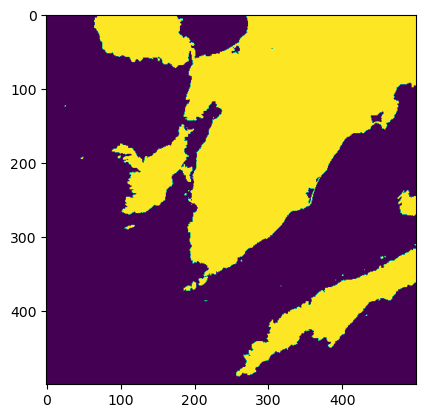

In [76]:
# Let's save the classification image
header = {
    'lines': cim.shape[0],
    'samples': cim.shape[1],
    'bands': 1,
    'header offset': '0',
    'file type': 'ENVI Standard',
    'data type': '4',
    'interleave': 'bil',
    'byte order': '0',
    'band names': ['Classification'],
    'mapping': ['water', 'land']
}

out_path = os.path.join(root, 'emit20240822T090158_rdn_class')
out = envi.create_image(
    envi_header(out_path),
    metadata=header,
    ext="",
    force=True,
)
del out

output = np.reshape(
    cim, 
    (cim.shape[0], 1, cim.shape[1])
)

out = envi.open(envi_header(out_path)).open_memmap(interleave='source', writable=True)
out[...] = output
del out

# Check our work
cds = envi.open(envi_header(out_path))
cim = cds.load()
plot = plt.imshow(cim)

print(cds.metadata['mapping'])

## 3. Setting up the ApplyOE inputs

Next, we have to correctly configure the ApplyOE run. We are running Isofit in multisurface mode, meaning that the forward model for land pixels will be different than the forward model for water pixels. For water pixels, we will be using a "Glint surface model" to represent the surface component of the forward model. The glint model allows us to retrieve the magnitude of sun glint and sky glint present in the scene. However, the glint model cannot be used for non-water pixels, which is why we must treat land and water pixels separately.

Using the glint model also means that we cannot (as of 12/20/2024) use the SRTMnet emulator to generate the lookup table (LUT) used for optimization. We are limited to Modtran to generate compatible LUTs, which can be extremely time consuming. For this example, we will use a prebuilt LUT, which will produce results faster (for the example's sake), but at the cost of accuracy.

There are many more parameters in the namespace than need to be explicitely passed into the apply_oe function. They are included here to give some context for the variables that could be passed through.


In [77]:
# Logging
logging_level = 'INFO'
log_file = os.path.join(root, 'log.txt')

# Inputs
input_radiance = os.path.join(root, 'emit20240822T090158_rdn')
input_loc = os.path.join(root, 'emit20240822T090158_loc')
input_obs = os.path.join(root, 'emit20240822T090158_obs')
surface_path = os.path.join(root, 'data','surface.mat')
surface_class = os.path.join(root, 'emit20240822T090158_rdn_class')

# Signal that we are not running new RT models
prebuilt_lut=os.path.join(root, 'lut_full', 'lut_clean.nc')

In [78]:
# Define the namespace
class InputNamespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

# Insert arguments here
args = InputNamespace(
    analytical_line=False,
    empirical_line=True,
    n_cores=os.cpu_count() - 1,
    ray_temp_dir='/tmp/ray',
    sensor='emit',
    num_neighbors=[50],
    logging_level=logging_level,
    log_file=log_file,
    input_radiance=input_radiance,
    input_loc=input_loc,
    input_obs=input_obs,
    config_file=None,
    emulator_base=None,
    lut_config_file=None,
    aerosol_climatology_path=None,
    working_directory=root,
    surface_path=surface_path,
    surface_class_file=surface_class,
    copy_input_files=0,
    channelized_uncertainty_path=None,
    model_discrepancy_path=None,
    modtran_path='dummy_path',
    rdn_factors_path=None,
    wavelength_path=None,
    pressure_elevation=False,
    multi_surface=True,
    segmentation_size=400,
    presolve=False,
    atmosphere_type='ATM_MIDLAT_SUMMER',
    surface_category=None,
    prebuilt_lut=prebuilt_lut,
    multiple_restarts=False,
    atm_sigma=[2],
    no_min_lut_spacing=False,
    inversion_windows=False,
    multipart_transmittance=True
)

## 4. Executing ApplyOE

Executing ApplyOE is a one line command when set up this way. When this is run for the first time, the full program will execute. Run times will vary deepending on whether analytical_line = True/False or empirical_line = True/False. Flagging either of these variables as true will initiate the super-pixel segmentation, which speeds up processing. 

If super-pixel segmentation is used, run times will be ~10 minutes.<br>
If super-pixel segmentation is not used, run times will be >20 minutes.

Both cases will vary as a function of the `n_cores` passed into the program. More cores, less time. Fewer cores, more time.

ApplyOE always checks for the presence of output files. At each stage, if the program finds the relevant outputs (e.g. segmentation will skip if the _subs files are present, Isofit.run will skip if the rfl_subs file is presnet). After the first run, that means that as long as the files remain in the output location, ApplyOE will not execute.

This is advanageous because it means that the whole program does not have to execute every time. If you want to re-run just a portion of the workflow, simply remove the relevant outputs. The disadvantage is that if you change the ApplyOE parameters, and simply try to re-run, the program will not re-execute. You have to remove output files as if you want to re-run with different parameters.

In [79]:
ray.shutdown()
apply_oe(
    args.input_radiance,
    args.input_loc,
    args.input_obs,
    args.working_directory,
    args.sensor,
    args.surface_path,
    surface_class_file=args.surface_class_file,
    prebuilt_lut=args.prebuilt_lut,
    segmentation_size=args.segmentation_size,
    multipart_transmittance=args.multipart_transmittance,
    analytical_line=True,
    n_cores=args.n_cores
)

2024-12-20 11:29:36,799	INFO worker.py:1781 -- Started a local Ray instance.
INFO:2024-12-20,11:29:37 || apply_oe.py:apply_oe() | Checking input data files...
INFO:2024-12-20,11:29:37 || apply_oe.py:apply_oe() | ...Data file checks complete
INFO:2024-12-20,11:29:37 || apply_oe.py:apply_oe() | Setting up files and directories....
INFO:2024-12-20,11:29:37 || template_construction.py:__init__() | Flightline ID: emit20240822T090158
INFO:2024-12-20,11:29:37 || apply_oe.py:apply_oe() | ...file/directory setup complete
INFO:2024-12-20,11:29:37 || apply_oe.py:apply_oe() | Using inversion windows: [[380.0, 1325.0], [1435, 1770.0], [1965.0, 2500.0]]
INFO:2024-12-20,11:29:37 || apply_oe.py:apply_oe() | No wavelength file provided. Obtaining wavelength grid from ENVI header of radiance cube.
INFO:2024-12-20,11:29:37 || apply_oe.py:apply_oe() | Wavelength units of nm inferred...converting to microns
INFO:2024-12-20,11:29:37 || apply_oe.py:apply_oe() | Observation means:
INFO:2024-12-20,11:29:37 || 

## 5. Examining the outputs

We can look at the outputs at both the superpixel level and full resolution of the original input image.

### 5.1 Reconstructing the superpixel results

We can use built in utilities to examine the subs_ output files that are generated from running the SLIC segmented input files. The utility is run in the command line in the form of:

```bash
isofit reconstruct_subs input_subs_path output_path lbl_working_path
```

We can look at the help call associated with the utlity:


In [80]:
res = os.system("isofit reconstruct_subs --help")

Usage: isofit reconstruct_subs [OPTIONS] INPUT_SUBS_PATH OUTPUT_PATH
                               LBL_WORKING_PATH

  Helper function to take the flat array that the superpixel algorithms work
  with and turn them into images at the full resolution of the input/output
  file. They will have the full array-resolution, but appear as coarser pixel-
  resolution images.

  args:

      input_subs_path:    Input subs file path.

      output_path:        Output reconstructed file path.

      lbl_working_path:   File path to label file for reconstruction.

  returns:     None

Options:
  --help  Show this message and exit.


In [81]:
# Now actually reconstruct the subs_ state file
output_root = os.path.join(root, 'output')
input_subs_path = os.path.join(root, 'output', 'emit20240822T090158_subs_state')
output_path = os.path.join(root, 'output', 'emit20240822T090158_subs_reconstruct_state')
lbl_working_path = os.path.join(root, 'output', 'emit20240822T090158_lbl')

res = os.system(f"isofit reconstruct_subs {input_subs_path} {output_path} {lbl_working_path}")

Done


### 5.2 Superpixel results

We can then show the superpixel results as images, rather than the flat files that they are processed in. The state file holds the solution for the full statevector. This includes both the surface reflectance solutions as well as any surface, atmosphere or instrument state. 

In this EMIT example the first 285 indices are surface reflectance, the next two are glint terms, and the final two are atmospheric elements.

In [82]:
state_ds = envi.open(envi_header(output_path))
state_im = state_ds.load()

rfl_idx = [i for i in range(285)]
glint_idx = [285, 286]
atm_idx = [287, 288]

# Glint bands
print([state_ds.metadata['band names'][i] for i in glint_idx])
# Atmospheric bands
print([state_ds.metadata['band names'][i] for i in atm_idx])

rfl = state_im[..., rfl_idx]
glint = state_im[..., glint_idx]
atm = state_im[..., atm_idx]

['SKY_GLINT', 'SUN_GLINT']
['AERFRAC_2', 'H2OSTR']


/Users/bgreenbe/micromamba/envs/isofit_env/lib/python3.10/site-packages/spectral/io/spyfile.py:226: NaNValueWarning: Image data contains NaN values.
  warnings.warn('Image data contains NaN values.', NaNValueWarning)


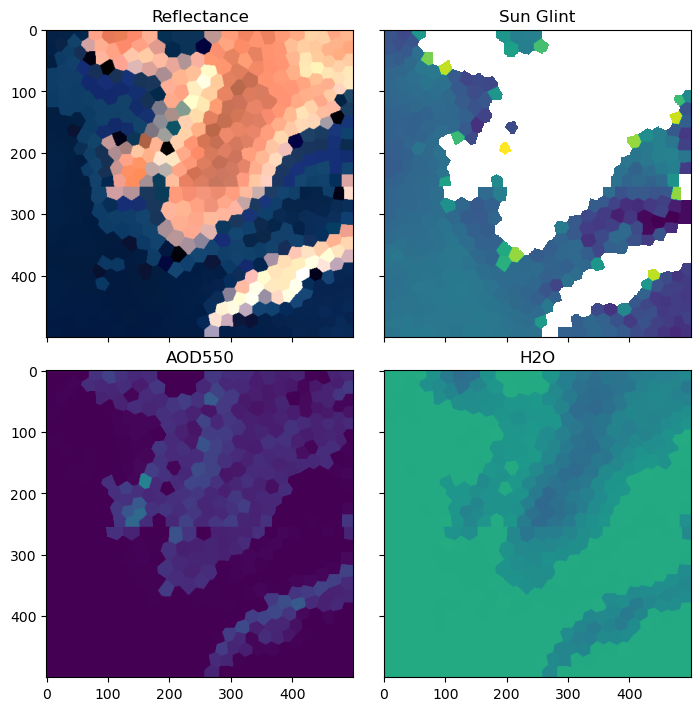

In [83]:
# Plot it
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, constrained_layout=True, figsize=(7, 7))
axs[0, 0].set_title('Reflectance')
rfl_plt = axs[0, 0].imshow(normalize_im(rfl[..., BANDS], vmin=0, vmax=0.1))

axs[0, 1].set_title('Sun Glint')
sun_plt = axs[0, 1].imshow(glint[..., 1])

axs[1, 0].set_title('AOD550')
aod_plt = axs[1, 0].imshow(atm[..., 0], vmin=.1, vmax=1)

axs[1, 1].set_title('H2O')
h2o_plt = axs[1, 1].imshow(atm[..., 1], vmin=1, vmax=6)

### 5.3 Results at full resolution

Currently, the empirical line method that we used here only produces full resolution measurements of surface reflectance.

In [84]:
full_rfl_path = os.path.join(root, 'output', 'emit20240822T090158_rfl')
rfl_ds  = envi.open(envi_header(full_rfl_path))
rfl_im = rfl_ds.load()
glint = rfl_im[..., 285:]

In [85]:
# Sample some spectra
water_point = [400, 100]
land_point = [100, 300]

# RDN
rdn_water = np.squeeze(rdn_im[water_point[0], water_point[1], :])
rdn_land = np.squeeze(rdn_im[land_point[0], land_point[1], :])

# RFL
rfl_water = np.copy(np.squeeze(rfl_im[water_point[0], water_point[1], :285]))
rfl_land = np.copy(np.squeeze(rfl_im[land_point[0], land_point[1], :285]))

# Bad Bands
inversion_windows = [[380.0, 1325.0], [1435, 1770.0], [1965.0, 2500.0]]
bbl = np.ones(wl.shape)
for win in inversion_windows:
    bbl[(wl >= win[0]) & (wl <= win[1])] = 0

bbl = bbl.astype(bool)

rfl_water[bbl] = None
rfl_land[bbl] = None

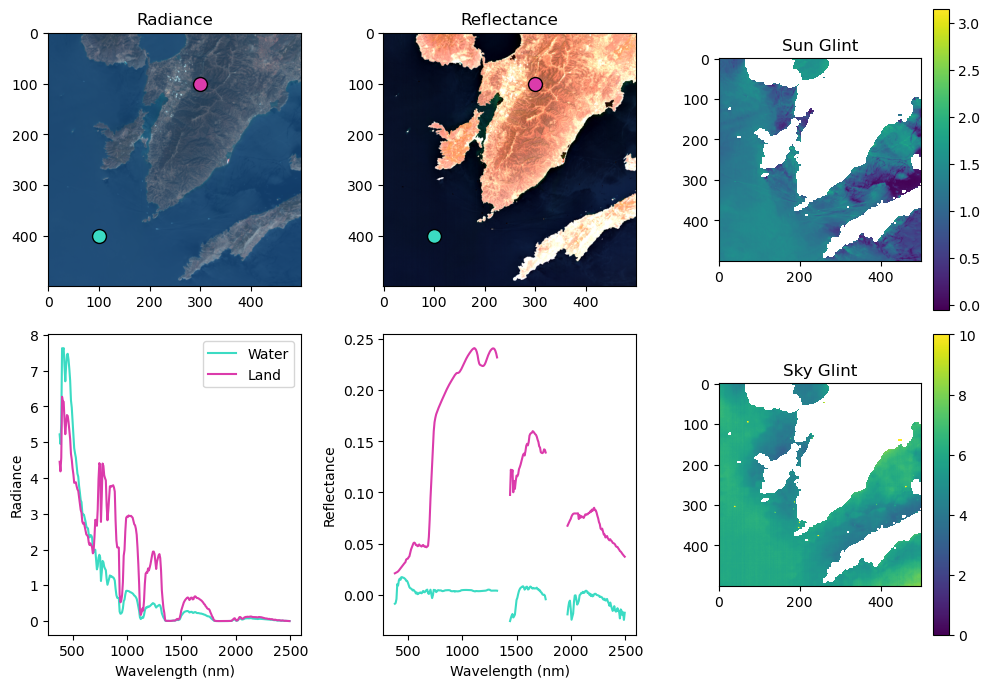

In [91]:
# Plot it
fig, axs = plt.subplots(2, 3, tight_layout=True, figsize=(10, 7))
axs = np.ravel(axs)
axs[0].set_title('Radiance')
rdn_plt = axs[0].imshow(normalize_im(rdn_im[..., BANDS]))
axs[0].scatter(water_point[1], water_point[0], facecolor='#3bdbc3', edgecolor='black', s=100)
axs[0].scatter(land_point[1], land_point[0], facecolor='#db3bab', edgecolor='black', s=100)

axs[1].set_title('Reflectance')
rfl_plt = axs[1].imshow(normalize_im(rfl_im[..., BANDS], vmin=0, vmax=0.1))
axs[1].scatter(water_point[1], water_point[0], facecolor='#3bdbc3', edgecolor='black', s=100)
axs[1].scatter(land_point[1], land_point[0], facecolor='#db3bab', edgecolor='black', s=100)

axs[2].set_title('Sun Glint')
sun_plt = axs[2].imshow(glint[..., 1])
plt.colorbar(sun_plt)

axs[3].plot(wl, rdn_water, color='#3bdbc3', label='Water')
axs[3].plot(wl, rdn_land, color='#db3bab', label='Land')
axs[3].set_xlabel('Wavelength (nm)')
axs[3].set_ylabel('Radiance')
axs[3].legend()


axs[4].plot(wl, rfl_water, color='#3bdbc3', label='Water')
axs[4].plot(wl, rfl_land, color='#db3bab', label='Land')
axs[4].set_xlabel('Wavelength (nm)')
lbl = axs[4].set_ylabel('Reflectance')

axs[5].set_title('Sky Glint')
sky_plt = axs[5].imshow(glint[..., 0], vmin=0, vmax=10)
plt.colorbar(sky_plt)
